In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import itertools
import random
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, metrics

from tensorflow.keras.applications import InceptionV3

from plot_utils import *

# 1. Train-validation split

In [16]:
df_all = pd.read_csv('Dataset/processed/chest_xray_images_properties.csv')
df_all.head()

,path,label,dataset,max,min,mean,std,height,width
0,Dataset/chest_xray/train/NORMAL/NORMAL2-IM-092...,NORMAL,train,255,0,124.391030,56.330762,2234,2359
1,Dataset/chest_xray/train/NORMAL/NORMAL2-IM-105...,NORMAL,train,255,0,115.710751,56.844688,1067,1422
2,Dataset/chest_xray/train/NORMAL/IM-0427-0001.jpeg,NORMAL,train,255,0,133.991183,65.503709,1357,1828
3,Dataset/chest_xray/train/NORMAL/NORMAL2-IM-126...,NORMAL,train,255,0,111.488999,68.965235,1495,1854
4,Dataset/chest_xray/train/NORMAL/IM-0656-0001-0...,NORMAL,train,255,0,148.148118,60.029570,1966,2194


In [3]:
train_val_df = df_all[(df_all['dataset'] == 'train') | (df_all['dataset'] == 'val')]
valid_size = 0.2
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=42)
train_df['dataset'] = 'train'
val_df['dataset'] = 'val'

test_df = df_all[df_all['dataset'] == 'test']

print("Before:")
print("Train:", len(df_all[df_all['dataset'] == 'train']))
print("Val:", len(df_all[df_all['dataset'] == 'val']))
print("------\nAfter:")
print("Train:", len(train_df))
print("Val:", len(val_df))

print("\nTest:", len(test_df))


Before:
Train: 5216
Val: 16
------
After:
Train: 4185
Val: 1047

Test: 624


# 2. Transfer learning with CNNs

The CNN's performance is suboptimal, likely due to its simple architecture constrained by computational resources and the small dataset of 5215 samples.

To overcome these limitations and improve performance, transfer learning offers a solution. By fine-tuning pre-trained models, typically trained on extensive datasets like ImageNet, we can leverage their learned features to enhance our model's capabilities for our specific task.

I'll utilize the InceptionV3 model.

## 2.1 Image transformation

InceptionV3 is pre-trained on ImageNet using color images (RGB). Therefore, the input images must also have three color channels, meaning I need to set color_mode='rgb' for the ImageDataGenerator.

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=5, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen = ImageDataGenerator(rescale=1.0/255)

img_size = (224, 224)
batch_size = 64 # 32, 64, 128

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle = True,
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle = False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


## 4.2 Load pre-trained model

The top layers should be excluded because the classification task for this model differs from the original training objective (`include_top=False`).

In [27]:
base_model = InceptionV3(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([
    base_model,
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(2, activation='softmax')
])

for layer in base_model.layers[-100:]:
    layer.trainable = True

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
count_normal = len(train_df[train_df['label'] == 'NORMAL'])
count_pneumonia = len(train_df[train_df['label'] == 'PNEUMONIA'])
count_total = len(train_df)

# Scaling by total/2 helps keep the loss to a similar magnitude - the sum of the weights of all examples stays the same.
weight_for_0 = (1 / count_normal) * (count_total / 2.0)
weight_for_1 = (1 / count_pneumonia) * (count_total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

# Define callbacks
checkpoint_path = "Models/Transfer_model/Callback/best_model.keras"
checkpoint_callback = ModelCheckpoint(checkpoint_path, 
                                      monitor='val_loss', 
                                      save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=5)

In [29]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weight,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Epoch 1/30


2024-05-18 16:28:12.535707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:75: Filling up shuffle buffer (this may take a while): 7 of 8
2024-05-18 16:28:13.939014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


66/66 ━━━━━━━━━━━━━━━━━━━━ 431s 6s/step - accuracy: 0.8486 - loss: 0.3193 - val_accuracy: 0.9417 - val_loss: 0.3070
Epoch 2/30


2024-05-18 16:34:56.299754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:75: Filling up shuffle buffer (this may take a while): 7 of 8
2024-05-18 16:34:58.299664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


66/66 ━━━━━━━━━━━━━━━━━━━━ 409s 6s/step - accuracy: 0.9537 - loss: 0.1135 - val_accuracy: 0.7555 - val_loss: 1.1568
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 362s 5s/step - accuracy: 0.9602 - loss: 0.0824 - val_accuracy: 0.9561 - val_loss: 0.1293
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 295s 4s/step - accuracy: 0.9620 - loss: 0.0903 - val_accuracy: 0.9761 - val_loss: 0.0491
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 287s 4s/step - accuracy: 0.9730 - loss: 0.0724 - val_accuracy: 0.9828 - val_loss: 0.0613
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 589s 9s/step - accuracy: 0.9774 - loss: 0.0553 - val_accuracy: 0.9713 - val_loss: 0.0818
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 287s 4s/step - accuracy: 0.9815 - loss: 0.0590 - val_accuracy: 0.7307 - val_loss: 1.1994
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 304s 4s/step - accuracy: 0.9762 - loss: 0.0572 - val_accuracy: 0.9475 - val_loss: 0.1508
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - accuracy: 0.9746 - loss: 0.0550 - val_accuracy: 0.8988 - val_loss: 0.

In [30]:
model.save(f'Models/Transfer_model/transfer_learning_model.keras')
print('Model saved!')

with open('Models/Transfer_model/training_history_transfer_learning_model.pkl', 'wb') as file:
    pickle.dump(history, file)

Model saved!


## 4.4 Visualize the loss and accuracy curves

In [32]:
model = tf.keras.models.load_model('Models/Transfer_model/transfer_learning_model.keras')

with open('Models/Transfer_model/training_history_transfer_learning_model.pkl', 'rb') as file:
    history = pickle.load(file)

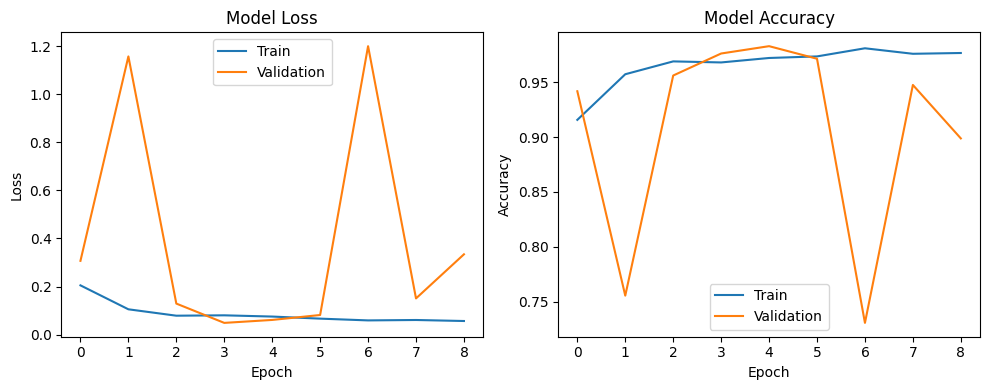

In [35]:
plot_training_history(history)

## 4.5 Make predictions on test dataset

In [36]:
test_loss, test_accuracy = model.evaluate(test_generator)
predictions = model.predict(test_generator)

y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
y_probs = predictions[:, 1]

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9472 - loss: 0.2023
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step
Test Loss: 0.2458
Test Accuracy: 0.9327


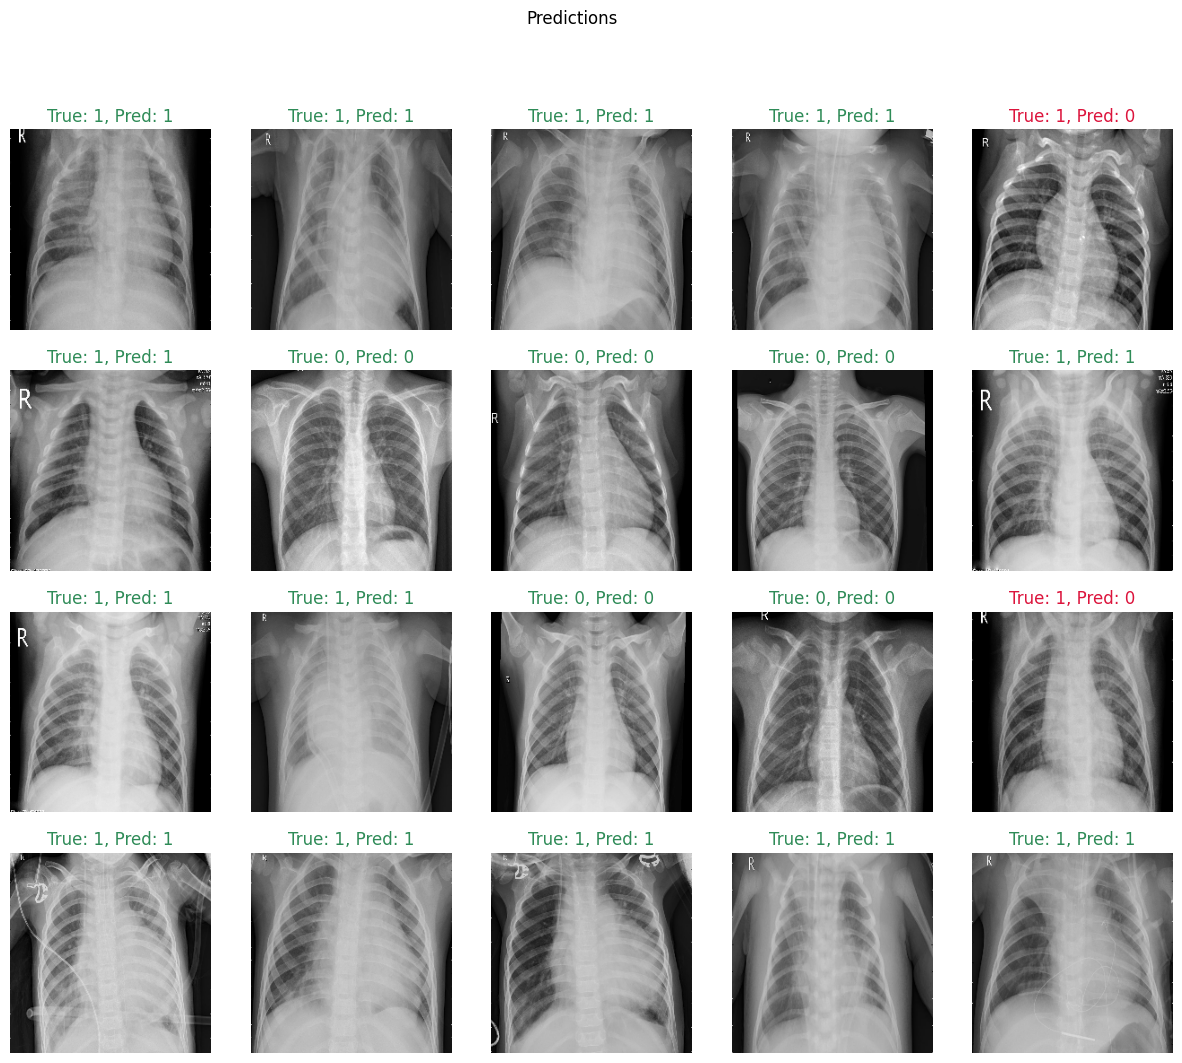

In [44]:
plot_predictions(test_generator, y_true, y_pred, num_images=20)

## 4.5 Evaluate results on test set


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       234
           1       0.97      0.92      0.94       390

    accuracy                           0.93       624
   macro avg       0.92      0.94      0.93       624
weighted avg       0.94      0.93      0.93       624


Evaluation scores:
* Accuracy: 0.9327
* Precision: 0.9703
* Recall: 0.9205
* F1-Score: 0.9447

Confusion matrix:


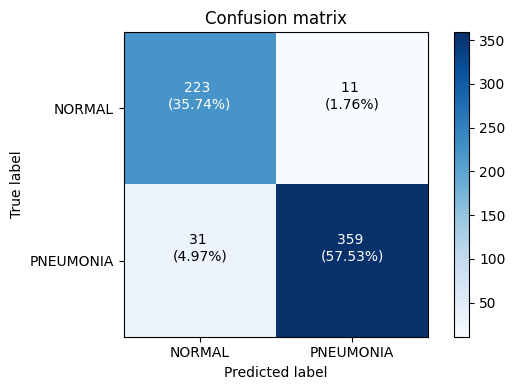

In [38]:
print('\nClassification Report:')
report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(len(test_generator.class_indices))])
print(report)

print('\nEvaluation scores:')
print_evaluation_scores(y_true, y_pred)

print('\nConfusion matrix:')
cm = confusion_matrix(y_true, y_pred)
classes = list(test_generator.class_indices.keys())
plot_confusion_matrix(cm, classes)

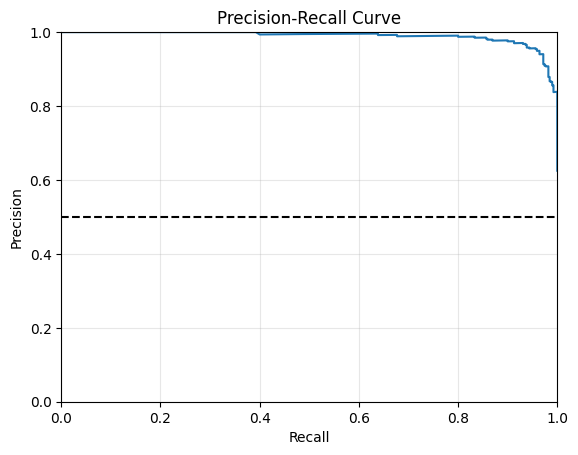

In [39]:
plot_precision_recall_curve(y_true, y_probs)

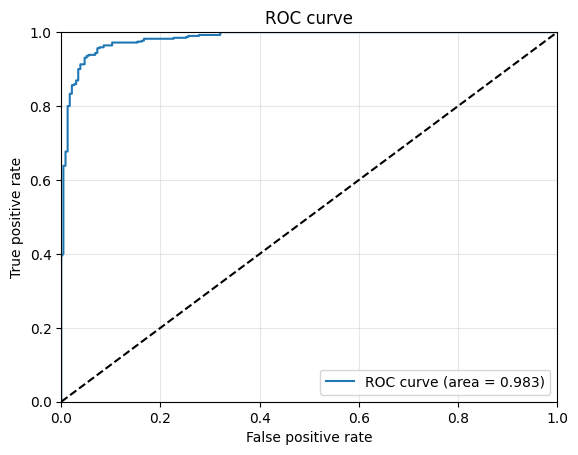

In [40]:
plot_roc_curve(y_true, y_probs)